# Exploring the UTx000 Extension Beacon Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

# Summary
This notebook helps look at the measurements taken during the study period for the various sensors on the beacons.

# Package Import

In [2]:
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

# Data Import

In [3]:
beacon_data = pd.read_csv('../data/processed/bpeace2-beacon.csv',index_col=0,parse_dates=True)
# show it off:
beacon_data.head()

,TVOC,eCO2,Lux,Visible,Infrared,NO2,T_NO2,RH_NO2,CO,T_CO,...,PM_N_4,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,Beacon,Beiwe,Fitbit,REDCap
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-01 17:15:00,0.0,400.0,-100.0,-100.0,-100.0,669362.437500,22.0,55.250000,-0.1,-100.0,...,45.066567,45.351743,5.528357,13.813757,20.262206,21.551901,30,idbkjh8u,22,4
2020-06-01 17:20:00,0.0,400.0,-100.0,-100.0,-100.0,40906.066667,22.0,54.166667,-0.1,-100.0,...,42.536739,42.735695,5.247584,11.059922,15.519927,16.411934,30,idbkjh8u,22,4
2020-06-01 17:25:00,0.0,400.0,-100.0,-100.0,-100.0,22156.680000,23.0,53.000000,-0.1,-100.0,...,37.865118,38.020652,4.680348,9.237404,12.707863,13.401960,30,idbkjh8u,22,4
2020-06-01 17:30:00,0.0,400.0,-100.0,-100.0,-100.0,15907.500000,23.0,52.000000,-0.1,-100.0,...,41.361894,41.520351,5.117388,9.768085,13.294004,13.999194,30,idbkjh8u,22,4
2020-06-01 17:35:00,0.0,400.0,-100.0,-100.0,-100.0,12495.000000,23.0,51.960000,-0.1,-100.0,...,40.015350,40.204947,4.935506,10.472929,14.724953,15.575364,30,idbkjh8u,22,4


## Base Visualization
Here we look at the raw, unaltered data in order to ascertain:
- what data are available? (see 4.1.1 notebook to see when participants actually measured data)
- what are typical measurements and what does this say?
- are their any misbehaving sensors?

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [9]:
dt = datetime(2020,8,28,11,1) - datetime(2020,8,21,18,31)

In [10]:
datetime(2020,5,25,11,59) + dt

datetime.datetime(2020, 6, 1, 4, 29)

In [12]:
test = beacon_data[beacon_data['Beacon'] == 13]

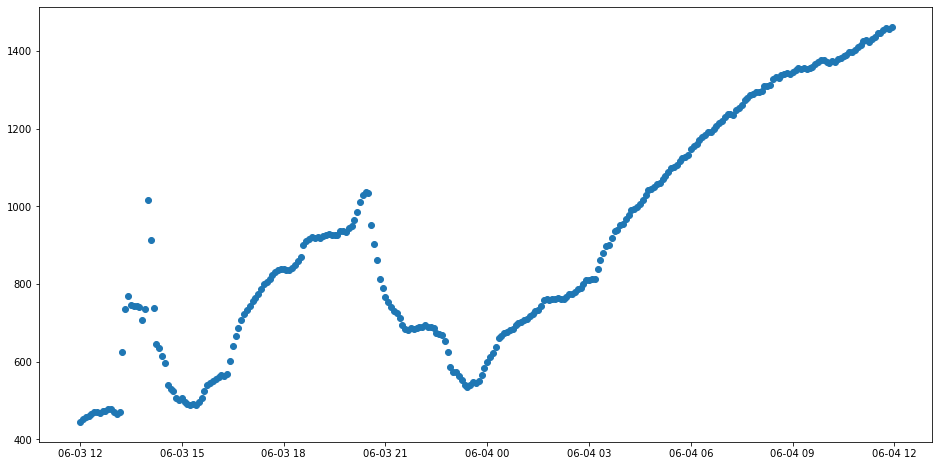

In [23]:
fig, ax = plt.subplots(figsize=(16,8))
test = test[datetime(2020,6,3,11,59):datetime(2020,6,4,11,59)]
ax.scatter(test.index,test['CO2'])

In [24]:
datetime(2020,6,3,13,59) + dt

datetime.datetime(2020, 6, 10, 6, 29)

In [30]:
corrected_dt = datetime(2020,6,10,11,21) - datetime(2020,6,3,13,17)
print(corrected_dt)

6 days, 22:04:00


In [27]:
datetime(2020,6,3,13,17) + corrected_dt

datetime.datetime(2020, 6, 10, 11, 21)

In [31]:
datetime(2020,8,21,18,31) + corrected_dt

datetime.datetime(2020, 8, 28, 16, 35)